In [1]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torch import optim

In [3]:
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.flows.base import Flow
from nflows.transforms.dropout import UniformStochasticDropout
from nflows.transforms.dropout import VariationalStochasticDropout
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform

In [4]:
#device = torch.device("cuda:0")
device = torch.device("cpu")

In [5]:
# This works with any size x
def p(x, n_probs):
    sums = torch.sum(x, axis=1)
    probs = torch.cos(torch.ger(sums, torch.arange(1, n_probs+1, dtype=torch.float32)))**2
    norm = torch.sum(probs, axis=1)

    for i in range(n_probs):
        probs[:,i] /= norm
    
    return probs

In [6]:
def generate(n, drop_indices):
    n_probs = torch.max(drop_indices) + 1
    x = torch.rand(n, drop_indices.shape[0])
    probs = p(x, n_probs)

    # Pick a prob
    probs_cumsum = torch.cumsum(probs, axis=1)

    # Tensor with bools that are true when r passes the cumprob
    larger_than_cumprob = torch.rand(n,1) < probs_cumsum
    # Do the arange trick to find first nonzero
    # This is the HIGHEST LABEL FROM DROP_INDICES THAT IS KEPT
    selected_index = torch.argmax(larger_than_cumprob*torch.arange(n_probs, 0, -1), axis=1)

    '''
    print("The index of the selected probability")
    print("This is also the highest label in drop_indices that is kept")
    print(selected_index)
    ''' 
    
    # Find the index of the first true
    drop_mask = drop_indices > selected_index[:,None]
    x[drop_mask] = 0
    
    return x

In [7]:
drop_indices = torch.tensor([0,0,1,1,1,2,3,3,4])
n_data = int(1e6)
x_data = generate(n_data, drop_indices).to(device)

In [8]:
num_layers = 6
base_dist_uniform = BoxUniform(torch.zeros(drop_indices.shape[0]), torch.ones(drop_indices.shape[0]))
base_dist_variational = BoxUniform(torch.zeros(drop_indices.shape[0]), torch.ones(drop_indices.shape[0]))

transforms_uniform = []
transforms_variational = []

transforms_uniform.append(UniformStochasticDropout(drop_indices))
transforms_variational.append(VariationalStochasticDropout(drop_indices))

for _ in range(num_layers):
    transforms_uniform.append(RandomPermutation(features=drop_indices.shape[0]))
    transforms_uniform.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=drop_indices.shape[0], 
        hidden_features=25,
        num_bins=10,
        num_blocks=4,
    ))

    transforms_variational.append(RandomPermutation(features=drop_indices.shape[0]))
    transforms_variational.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=drop_indices.shape[0], 
        hidden_features=25,
        num_bins=10,
        num_blocks=4,
    ))

transform_uniform = CompositeTransform(transforms_uniform)
transform_variational = CompositeTransform(transforms_variational)

flow_uniform = Flow(transform_uniform, base_dist_uniform).to(device)
flow_variational = Flow(transform_variational, base_dist_variational).to(device)

optimizer_uniform = optim.Adam(flow_uniform.parameters())
optimizer_variational = optim.Adam(flow_variational.parameters())

In [9]:
n_epochs = 10
batch_size = 1000
n_batches = m.ceil(x_data.shape[0]/batch_size)

for epoch in range(n_epochs):
    permutation = torch.randperm(x_data.shape[0], device=device)    

    # Loop over batches
    cum_loss_uniform = 0
    cum_loss_variational = 0
    for batch in range(n_batches):
        # Set up the batch
        batch_begin = batch*batch_size
        batch_end   = min( (batch+1)*batch_size, x_data.shape[0]-1 )
        indices = permutation[batch_begin:batch_end]
        batch_x = x_data[indices]
        
        # Take a step
        optimizer_uniform.zero_grad()
        optimizer_variational.zero_grad()

        loss_uniform = -flow_uniform.log_prob(inputs=batch_x).mean()
        loss_variational = -flow_variational.log_prob(inputs=batch_x).mean()

        loss_uniform.backward()
        loss_variational.backward()

        optimizer_uniform.step()
        optimizer_variational.step()

        # Compute cumulative loss
        cum_loss_uniform = (cum_loss_uniform*batch + loss_uniform.item())/(batch+1)
        cum_loss_variational = (cum_loss_variational*batch + loss_variational.item())/(batch+1)

        print("epoch = ", epoch, "batch = ",batch+1, "/", n_batches, "loss_uniform = ", cum_loss_uniform, " loss_variational = ", cum_loss_variational)

iational =  4.651031764348348
epoch =  0 batch =  16 / 1000 loss_uniform =  3.1667862981557846  loss_variational =  4.585195153951645
epoch =  0 batch =  17 / 1000 loss_uniform =  3.1379966735839844  loss_variational =  4.530941205866196
epoch =  0 batch =  18 / 1000 loss_uniform =  3.1137917836507163  loss_variational =  4.469945695665148
epoch =  0 batch =  19 / 1000 loss_uniform =  3.085033705360011  loss_variational =  4.416187173441837
epoch =  0 batch =  20 / 1000 loss_uniform =  3.058369994163513  loss_variational =  4.356424140930176
epoch =  0 batch =  21 / 1000 loss_uniform =  3.0390183471498036  loss_variational =  4.306363548551287
epoch =  0 batch =  22 / 1000 loss_uniform =  3.0156871622258965  loss_variational =  4.255757873708552
epoch =  0 batch =  23 / 1000 loss_uniform =  2.991709315258524  loss_variational =  4.205656652865202
epoch =  0 batch =  24 / 1000 loss_uniform =  2.9681528309981027  loss_variational =  4.158717244863509
epoch =  0 batch =  25 / 1000 loss_un

KeyboardInterrupt: 

In [10]:
n_sample = 10000
with torch.no_grad():
    x_uniform = flow_uniform.sample(n_sample).cpu().numpy()
    x_variational = flow_variational.sample(n_sample).cpu().numpy()
x_data_plot = x_data.cpu()[:n_sample,:].numpy()

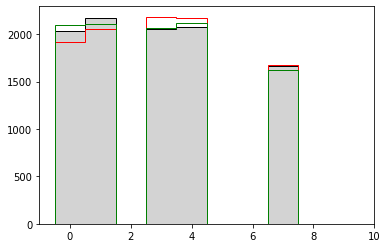

In [11]:
bins = np.linspace(-0.5, drop_indices.shape[0]+0.5, drop_indices.shape[0]+2)
plt.hist(np.sum(x_data_plot == 0, axis=1), histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins = bins)
plt.hist(np.sum(x_uniform == 0, axis=1), edgecolor="red", histtype="step", bins = bins)
plt.hist(np.sum(x_variational == 0, axis=1), edgecolor="green", histtype="step", bins = bins)
plt.show()

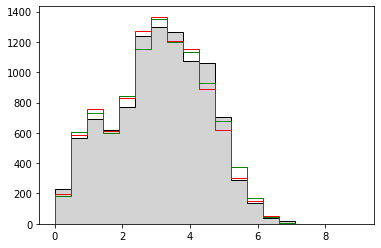

In [12]:
bins = np.linspace(0, drop_indices.shape[0], 20)
plt.hist(np.sum(x_data_plot, axis=1), histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins = bins)
plt.hist(np.sum(x_uniform, axis=1), edgecolor="red", histtype="step", bins = bins)
plt.hist(np.sum(x_variational, axis=1), edgecolor="green", histtype="step", bins = bins)
plt.show()

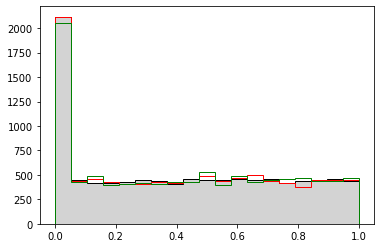

In [13]:
bins = np.linspace(0, 1, 20)
plt.hist(x_data_plot[:,2], histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins = bins)
plt.hist(x_uniform[:,2], edgecolor="red", histtype="step", bins = bins)
plt.hist(x_variational[:,2], edgecolor="green", histtype="step", bins = bins)
plt.show()